## Кластеризация текста на основе датасета с 250 фильмами

___

### 1. Подключение библиотек

In [1]:
import pandas as pd
import string
import re
import nltk
import pymorphy3

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ROG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ROG\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df =pd.read_csv("IMDB_dataset.csv")

In [3]:
df = df.drop(columns="Unnamed: 0")

In [4]:
df.head()

,title,year,description,duration,genre,country
0,The Shawshank Redemption,1994,"Банкир, осужденный за уксорицид, образует друж...",2 hours 22 minutes,"Epic, Period Drama, Prison Drama, Drama",United States
1,The Godfather,1972,Старение патриарха организованной криминальной...,2 hours 55 minutes,"Epic, Gangster, Tragedy, Crime, Drama",United States
2,The Dark Knight,2008,"Когда угроза, известная как Джокер, наносит ущ...",2 hours 32 minutes,"Action Epic, Epic, Superhero, Tragedy, Action,...",United States
3,The Godfather Part II,1974,Ранняя жизнь и карьера Вито Корлеоне в 1920 -х...,3 hours 22 minutes,"Epic, Gangster, Tragedy, Crime, Drama",United States
4,12 Angry Men,1957,Присяжные в суде по делу об убийстве в Нью -Йо...,1 hour 36 minutes,"Legal Drama, Psychological Drama, Crime, Drama",United States


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        248 non-null    object
 1   year         250 non-null    int64 
 2   description  250 non-null    object
 3   duration     250 non-null    object
 4   genre        250 non-null    object
 5   country      250 non-null    object
dtypes: int64(1), object(5)
memory usage: 11.8+ KB


___

### 2. Предварительная обработка данных

1. Перевод всех букв в тексте в нижний регистр
2. Удаление знаков препинания
3. Токенизация по словам
4. Удаление стоп слов
5. Стемминг (приведение слов к нормальной форме)
6. Лемматизация

In [6]:
def remove_punctuation(text): 
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])

def remove_numbers(text): 
    return ''.join([i if not i.isdigit() else ' ' for i in text])

def remove_multiple_spaces(text): 
    return re.sub(r'\s+', ' ', text, flags=re.I)

st = '❯\xa0—«»'
def remove_othersymbol(text):
    return ''.join([ch if ch not in st else ' ' for ch in text])

In [7]:
df['text_new'] = [remove_multiple_spaces(remove_numbers(remove_othersymbol(remove_punctuation(text.lower())))) for text in df['description']]

In [8]:
df.head()

,title,year,description,duration,genre,country,text_new
0,The Shawshank Redemption,1994,"Банкир, осужденный за уксорицид, образует друж...",2 hours 22 minutes,"Epic, Period Drama, Prison Drama, Drama",United States,банкир осужденный за уксорицид образует дружбу...
1,The Godfather,1972,Старение патриарха организованной криминальной...,2 hours 55 minutes,"Epic, Gangster, Tragedy, Crime, Drama",United States,старение патриарха организованной криминальной...
2,The Dark Knight,2008,"Когда угроза, известная как Джокер, наносит ущ...",2 hours 32 minutes,"Action Epic, Epic, Superhero, Tragedy, Action,...",United States,когда угроза известная как джокер наносит ущер...
3,The Godfather Part II,1974,Ранняя жизнь и карьера Вито Корлеоне в 1920 -х...,3 hours 22 minutes,"Epic, Gangster, Tragedy, Crime, Drama",United States,ранняя жизнь и карьера вито корлеоне в х годах...
4,12 Angry Men,1957,Присяжные в суде по делу об убийстве в Нью -Йо...,1 hour 36 minutes,"Legal Drama, Psychological Drama, Crime, Drama",United States,присяжные в суде по делу об убийстве в нью йор...


In [9]:
russian_stopwords = stopwords.words("russian") 
russian_stopwords.extend(['т.д.', 'т', 'д', 'это','который', 'которая', 'с','своём','всем','наш', 'свой', 'ещё', "еще", "также", "так же", "всякий"]) 

In [10]:
def tokenize_text(text):
    t = word_tokenize(text)
    tokens = [token for token in t if not re.search(r'[a-zA-Z]', token)]
    text = " ".join(tokens)
    return text

In [11]:
df['tokenize_texts'] = df['text_new'].apply(tokenize_text)

In [12]:
stemmer = SnowballStemmer("russian")

stem_list = []
for text in (df['tokenize_texts']):
    try:
        tokens = word_tokenize(text)
        res = list()
        for word in tokens:
            p = stemmer.stem(word)
            res.append(p)
        text = " ".join(res)
        stem_list.append(text)
    except Exception as e:
        print(e)
        
df['text_stem'] = stem_list

In [13]:
morph = pymorphy3.MorphAnalyzer(lang='ru')

In [14]:
%%time
lemm_texts_list = []
for text in df['tokenize_texts']:
    try:
        tokens = word_tokenize(text)
        res = []
        for word in tokens:
            if word.lower() not in russian_stopwords:
                p = morph.parse(word)[0]
                res.append(p.normal_form)
        text = " ".join(res)
        lemm_texts_list.append(text)
    except Exception as e:
        print(e)
        lemm_texts_list.append("")

df['text_lemm'] = lemm_texts_list


CPU times: total: 312 ms
Wall time: 302 ms


In [15]:
df.head()

,title,year,description,duration,genre,country,text_new,tokenize_texts,text_stem,text_lemm
0,The Shawshank Redemption,1994,"Банкир, осужденный за уксорицид, образует друж...",2 hours 22 minutes,"Epic, Period Drama, Prison Drama, Drama",United States,банкир осужденный за уксорицид образует дружбу...,банкир осужденный за уксорицид образует дружбу...,банкир осужден за уксорицид образ дружб за чет...,банкир осудить уксорицид образовать дружба чет...
1,The Godfather,1972,Старение патриарха организованной криминальной...,2 hours 55 minutes,"Epic, Gangster, Tragedy, Crime, Drama",United States,старение патриарха организованной криминальной...,старение патриарха организованной криминальной...,старен патриарх организова криминальн династ п...,старение патриарх организовать криминальный ди...
2,The Dark Knight,2008,"Когда угроза, известная как Джокер, наносит ущ...",2 hours 32 minutes,"Action Epic, Epic, Superhero, Tragedy, Action,...",United States,когда угроза известная как джокер наносит ущер...,когда угроза известная как джокер наносит ущер...,когд угроз известн как джокер нанос ущерб и ха...,угроза известный джокер наносить ущерб хаос на...
3,The Godfather Part II,1974,Ранняя жизнь и карьера Вито Корлеоне в 1920 -х...,3 hours 22 minutes,"Epic, Gangster, Tragedy, Crime, Drama",United States,ранняя жизнь и карьера вито корлеоне в х годах...,ранняя жизнь и карьера вито корлеоне в х годах...,ран жизн и карьер вит корлеон в х год изобража...,ранний жизнь карьера вить корлеон х год изобра...
4,12 Angry Men,1957,Присяжные в суде по делу об убийстве в Нью -Йо...,1 hour 36 minutes,"Legal Drama, Psychological Drama, Crime, Drama",United States,присяжные в суде по делу об убийстве в нью йор...,присяжные в суде по делу об убийстве в нью йор...,присяжн в суд по дел об убийств в нью йорк раз...,присяжный суд дело убийство нью йорк разочаров...


___

# Облако слов

In [16]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
# Получение текстовой строки из списка слов
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus

# Получение списка всех слов в корпусе
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus

# Получение облака слов
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

<Axes: >

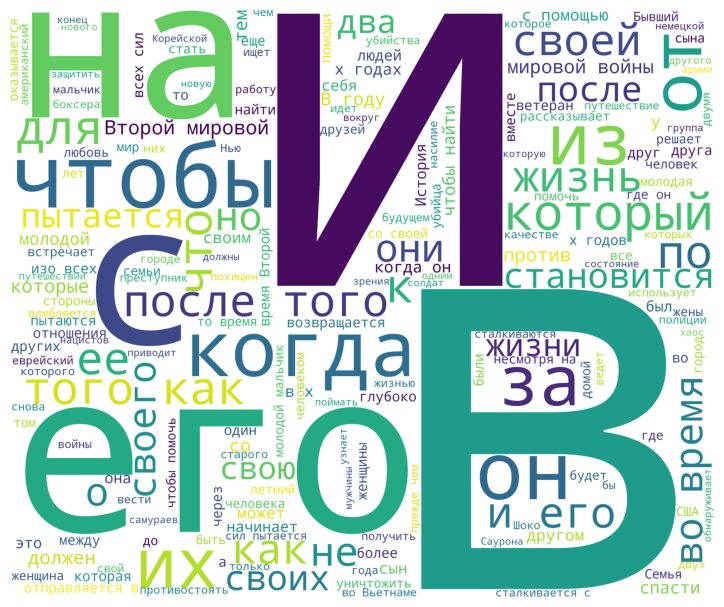

In [18]:
corpus = get_corpus(df['description'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

<Axes: >

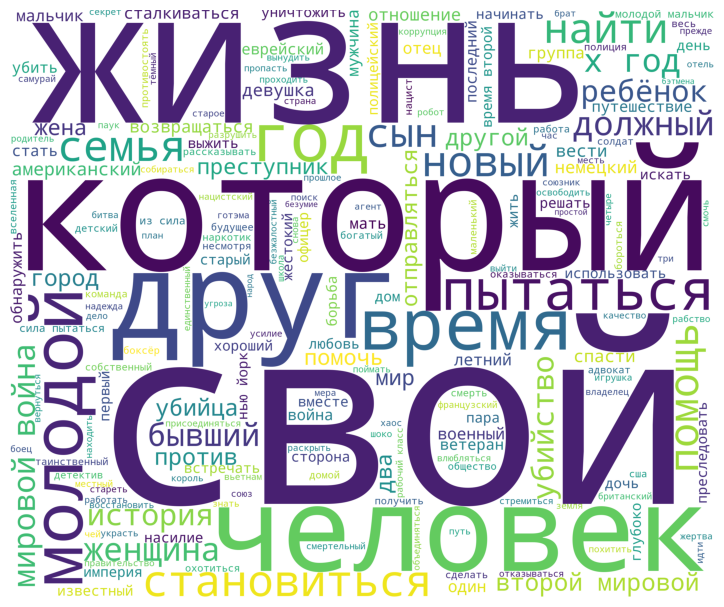

In [19]:
corpus = get_corpus(df['text_lemm'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

___

## Векторизация текстовых данных

#### **Bag of words**

Смотрим наличие слов в текстовых данных

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
df['text_lemm'][0]

'банкир осудить уксорицид образовать дружба четверть век закалённый осудить сохранять невиновность пытаться оставаться надежда простой сострадание'

In [22]:
vectorizer = CountVectorizer()
vectorizer.fit(df['text_lemm'])

CountVectorizer()

In [23]:
print(vectorizer.vocabulary_)

{'банкир': 68, 'осудить': 1164, 'уксорицид': 1989, 'образовать': 1087, 'дружба': 470, 'четверть': 2105, 'век': 173, 'закалённый': 522, 'сохранять': 1783, 'невиновность': 1009, 'пытаться': 1522, 'оставаться': 1154, 'надежда': 949, 'простой': 1493, 'сострадание': 1780, 'старение': 1817, 'патриарх': 1225, 'организовать': 1140, 'криминальный': 764, 'династия': 432, 'передавать': 1235, 'контроль': 738, 'тайна': 1883, 'империя': 613, 'неохотный': 1037, 'сын': 1878, 'угроза': 1968, 'известный': 588, 'джокер': 423, 'наносить': 967, 'ущерб': 2019, 'хаос': 2056, 'народ': 976, 'готэма': 356, 'бэтмена': 157, 'джеймс': 414, 'гордон': 349, 'харви': 2058, 'дента': 393, 'должный': 450, 'работать': 1528, 'вместе': 209, 'положить': 1329, 'конец': 729, 'безумие': 83, 'ранний': 1556, 'жизнь': 501, 'карьера': 678, 'вить': 199, 'корлеон': 746, 'год': 341, 'изображаться': 600, 'время': 264, 'майкл': 842, 'расширять': 1571, 'подтягивать': 1306, 'власть': 204, 'отношение': 1182, 'синдикат': 1699, 'семейный': 1

In [24]:
vectorizer = CountVectorizer(analyzer='word', stop_words=russian_stopwords, ngram_range=(1, 3), min_df=2)
count_matrix = vectorizer.fit_transform(df['text_lemm'])

In [25]:
count_matrix.shape

(250, 741)

In [26]:
vectorizer.get_feature_names_out()[45000:46000]

array([], dtype=object)

In [27]:
print(count_matrix)

  (0, 372)	1
  (0, 53)	1
  (0, 531)	1
  (0, 327)	1
  (0, 513)	1
  (0, 619)	1
  (1, 421)	1
  (1, 221)	1
  (1, 659)	1
  (2, 684)	1
  (2, 215)	1
  (2, 711)	1
  (2, 336)	1
  (2, 131)	1
  (2, 49)	1
  (2, 154)	1
  (2, 160)	1
  (2, 536)	1
  (2, 73)	1
  (2, 447)	1
  (2, 257)	1
  (2, 22)	1
  (2, 448)	1
  (3, 659)	1
  (3, 179)	1
  :	:
  (247, 340)	1
  (247, 532)	1
  (247, 28)	1
  (247, 604)	1
  (248, 175)	2
  (248, 362)	1
  (248, 12)	1
  (248, 176)	1
  (248, 499)	1
  (248, 213)	1
  (248, 420)	1
  (248, 184)	1
  (248, 564)	1
  (249, 531)	1
  (249, 719)	1
  (249, 643)	1
  (249, 624)	1
  (249, 677)	1
  (249, 533)	1
  (249, 585)	1
  (249, 482)	1
  (249, 678)	1
  (249, 300)	1
  (249, 608)	1
  (249, 193)	1


### **TF-IDF**

Вычисляем «относительную частоту» появления слова в одном документе по сравнению с его частотой во всех разом

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000,
                                 min_df=0.01, stop_words=russian_stopwords,
                                 ngram_range=(1,3))

In [30]:
%%time
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text_lemm'])

CPU times: total: 15.6 ms
Wall time: 14.9 ms


In [31]:
tfidf_matrix.shape

(250, 328)

In [32]:
tfidf_vectorizer.get_feature_names_out()[:100]

array(['агент', 'адвокат', 'американский', 'англия', 'анджелес', 'армия',
       'банда', 'бандит', 'безжалостный', 'безумие', 'битва', 'близкий',
       'бог', 'богатый', 'боевой', 'боец', 'боксёр', 'бороться', 'борьба',
       'брат', 'британский', 'бродяга', 'будущее', 'бывший', 'бэтмена',
       'век', 'вернуться', 'вести', 'весь', 'ветеран', 'взять',
       'владелец', 'власть', 'влюбляться', 'вместе', 'военный',
       'возвращаться', 'воин', 'война', 'вокруг', 'волшебный',
       'восстановить', 'время', 'время второй', 'время второй мировой',
       'вселенная', 'вскоре', 'встречать', 'второй', 'второй мировой',
       'второй мировой война', 'выжить', 'выйти', 'вынудить', 'выполнить',
       'высокий', 'вьетнам', 'гангстер', 'глубоко', 'го', 'го век', 'год',
       'город', 'готэма', 'гражданский', 'группа', 'дарт', 'девочка',
       'девушка', 'действие', 'дело', 'день', 'депрессия', 'детектив',
       'детский', 'джон', 'должный', 'дом', 'домой', 'дочь', 'друг',
       'друг

In [33]:
print(tfidf_matrix)

  (0, 25)	0.5167360839695784
  (0, 234)	0.36095022211117994
  (0, 150)	0.5366385402397056
  (0, 227)	0.5609971780776377
  (1, 103)	0.7624497542326485
  (1, 297)	0.6470474266006888
  (2, 309)	0.2914903013286871
  (2, 101)	0.259749195819409
  (2, 316)	0.2788337195118841
  (2, 154)	0.2914903013286871
  (2, 63)	0.2788337195118841
  (2, 24)	0.2914903013286871
  (2, 76)	0.212860433244441
  (2, 238)	0.2788337195118841
  (2, 34)	0.26849253919571947
  (2, 204)	0.2914903013286871
  (2, 115)	0.26849253919571947
  (2, 9)	0.2914903013286871
  (2, 205)	0.2914903013286871
  (3, 297)	0.4159611673650153
  (3, 89)	0.3119428678272945
  (3, 61)	0.3209930504045297
  (3, 42)	0.33087977268802343
  (3, 32)	0.5500444669475355
  (3, 182)	0.4632505547264193
  :	:
  (246, 252)	0.3185188383504078
  (246, 64)	0.35744153846841736
  (247, 234)	0.24532434668923986
  (247, 89)	0.21623763080910577
  (247, 267)	0.27843565427552447
  (247, 151)	0.2739377414108153
  (247, 306)	0.31330655832578774
  (247, 268)	0.33976928536

___

## Кластеризация данных

### **K-means**

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

  File "c:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


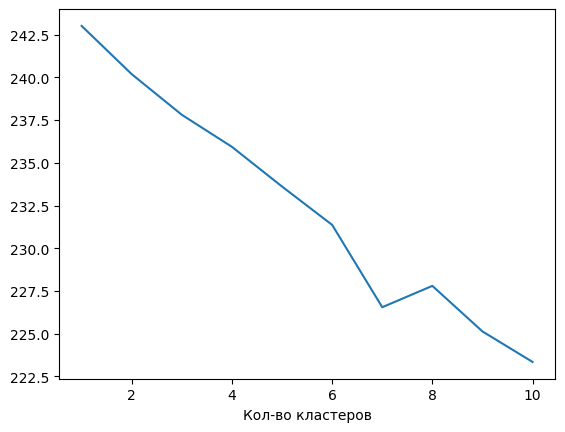

In [35]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.xlabel('Кол-во кластеров')
plt.show()

In [36]:
kmeans = KMeans(init='k-means++', n_clusters=7, n_init=10, random_state = 42)

In [37]:
kmeans.fit(tfidf_matrix)

KMeans(n_clusters=7, n_init=10, random_state=42)

In [38]:
pred=kmeans.fit_predict(tfidf_matrix)

cluster
1    99
0    38
6    30
4    30
2    24
5    17
3    12
Name: count, dtype: int64


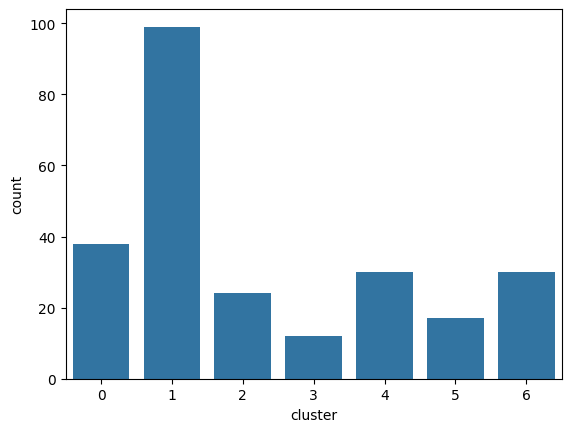

In [39]:
# Смотрим распределение по кластерам
df['cluster'] = pred
print(df['cluster'].value_counts())
sns.countplot(x='cluster', data=df)
plt.show()

In [40]:
df.head()

,title,year,description,duration,genre,country,text_new,tokenize_texts,text_stem,text_lemm,cluster
0,The Shawshank Redemption,1994,"Банкир, осужденный за уксорицид, образует друж...",2 hours 22 minutes,"Epic, Period Drama, Prison Drama, Drama",United States,банкир осужденный за уксорицид образует дружбу...,банкир осужденный за уксорицид образует дружбу...,банкир осужден за уксорицид образ дружб за чет...,банкир осудить уксорицид образовать дружба чет...,1
1,The Godfather,1972,Старение патриарха организованной криминальной...,2 hours 55 minutes,"Epic, Gangster, Tragedy, Crime, Drama",United States,старение патриарха организованной криминальной...,старение патриарха организованной криминальной...,старен патриарх организова криминальн династ п...,старение патриарх организовать криминальный ди...,5
2,The Dark Knight,2008,"Когда угроза, известная как Джокер, наносит ущ...",2 hours 32 minutes,"Action Epic, Epic, Superhero, Tragedy, Action,...",United States,когда угроза известная как джокер наносит ущер...,когда угроза известная как джокер наносит ущер...,когд угроз известн как джокер нанос ущерб и ха...,угроза известный джокер наносить ущерб хаос на...,1
3,The Godfather Part II,1974,Ранняя жизнь и карьера Вито Корлеоне в 1920 -х...,3 hours 22 minutes,"Epic, Gangster, Tragedy, Crime, Drama",United States,ранняя жизнь и карьера вито корлеоне в х годах...,ранняя жизнь и карьера вито корлеоне в х годах...,ран жизн и карьер вит корлеон в х год изобража...,ранний жизнь карьера вить корлеон х год изобра...,5
4,12 Angry Men,1957,Присяжные в суде по делу об убийстве в Нью -Йо...,1 hour 36 minutes,"Legal Drama, Psychological Drama, Crime, Drama",United States,присяжные в суде по делу об убийстве в нью йор...,присяжные в суде по делу об убийстве в нью йор...,присяжн в суд по дел об убийств в нью йорк раз...,присяжный суд дело убийство нью йорк разочаров...,1


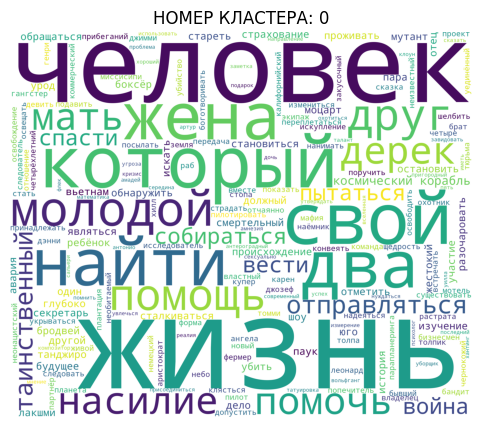

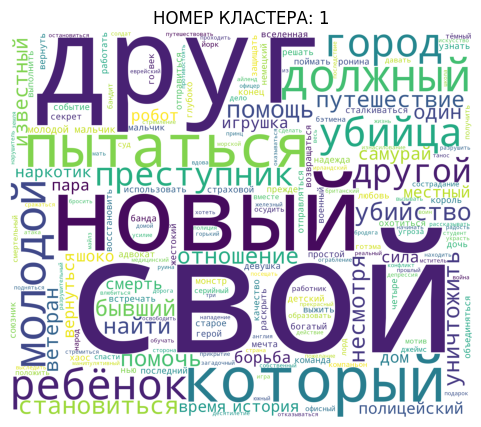

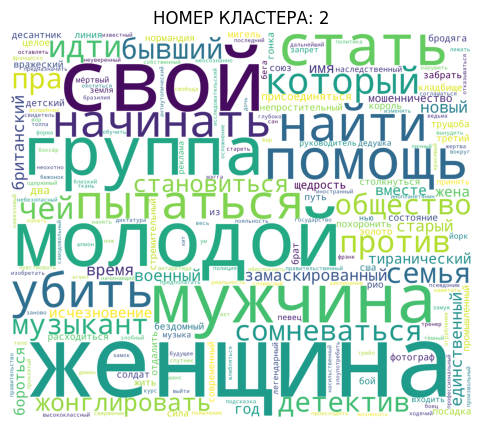

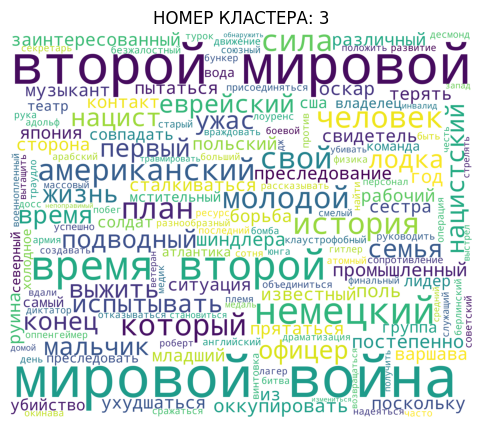

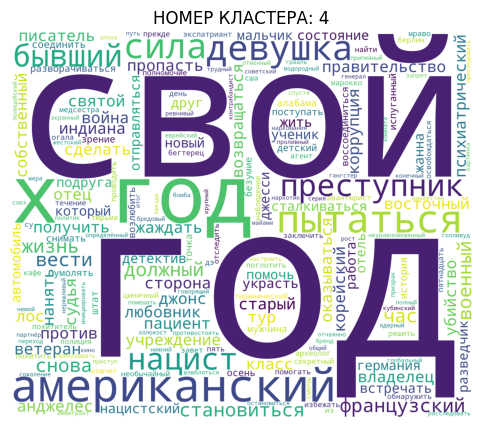

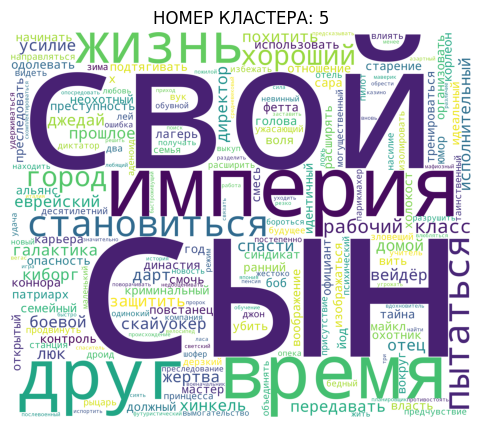

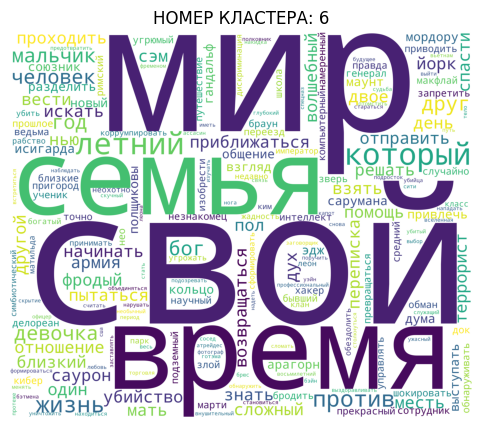

In [41]:
for i in sorted(df['cluster'].unique()):
    corpus = get_corpus(df[df['cluster'] == i].text_lemm.values)
    procWordCloud = get_wordCloud(corpus)
    
    fig = plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(procWordCloud)
    plt.axis('off')
    plt.title(f'НОМЕР КЛАСТЕРА: {i}')
    plt.subplot(1, 2, 1)

___

## Классификация

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [43]:
df.head()

,title,year,description,duration,genre,country,text_new,tokenize_texts,text_stem,text_lemm,cluster
0,The Shawshank Redemption,1994,"Банкир, осужденный за уксорицид, образует друж...",2 hours 22 minutes,"Epic, Period Drama, Prison Drama, Drama",United States,банкир осужденный за уксорицид образует дружбу...,банкир осужденный за уксорицид образует дружбу...,банкир осужден за уксорицид образ дружб за чет...,банкир осудить уксорицид образовать дружба чет...,1
1,The Godfather,1972,Старение патриарха организованной криминальной...,2 hours 55 minutes,"Epic, Gangster, Tragedy, Crime, Drama",United States,старение патриарха организованной криминальной...,старение патриарха организованной криминальной...,старен патриарх организова криминальн династ п...,старение патриарх организовать криминальный ди...,5
2,The Dark Knight,2008,"Когда угроза, известная как Джокер, наносит ущ...",2 hours 32 minutes,"Action Epic, Epic, Superhero, Tragedy, Action,...",United States,когда угроза известная как джокер наносит ущер...,когда угроза известная как джокер наносит ущер...,когд угроз известн как джокер нанос ущерб и ха...,угроза известный джокер наносить ущерб хаос на...,1
3,The Godfather Part II,1974,Ранняя жизнь и карьера Вито Корлеоне в 1920 -х...,3 hours 22 minutes,"Epic, Gangster, Tragedy, Crime, Drama",United States,ранняя жизнь и карьера вито корлеоне в х годах...,ранняя жизнь и карьера вито корлеоне в х годах...,ран жизн и карьер вит корлеон в х год изобража...,ранний жизнь карьера вить корлеон х год изобра...,5
4,12 Angry Men,1957,Присяжные в суде по делу об убийстве в Нью -Йо...,1 hour 36 minutes,"Legal Drama, Psychological Drama, Crime, Drama",United States,присяжные в суде по делу об убийстве в нью йор...,присяжные в суде по делу об убийстве в нью йор...,присяжн в суд по дел об убийств в нью йорк раз...,присяжный суд дело убийство нью йорк разочаров...,1


In [44]:
X = df.drop(columns=['title', 'genre', 'description', 'text_new', 'tokenize_texts', 'text_stem', 'text_lemm'])  # Признаки
y = df['cluster']  # Целевая переменная (метки кластеров)

In [45]:
X.head()

,year,duration,country,cluster
0,1994,2 hours 22 minutes,United States,1
1,1972,2 hours 55 minutes,United States,5
2,2008,2 hours 32 minutes,United States,1
3,1974,3 hours 22 minutes,United States,5
4,1957,1 hour 36 minutes,United States,1


In [46]:
# Список уникальных стран
unique_countries = [
    'United States', 'New Zealand', 'Italy', 'Germany', 'Japan',
    'Brazil', 'France', 'South Korea', 'United Kingdom', 'Canada',
    'India', 'West Germany', 'Lebanon', 'Soviet Union', 'Denmark',
    'Iran', 'Mexico', 'Spain', 'Argentina', 'Australia', 'Ireland',
    'Sweden', 'Turkey'
]

# Создаем словарь
countries = {country: idx for idx, country in enumerate(unique_countries)}

In [47]:
X['country_code'] = X['country'].apply(lambda x: countries[x])

In [48]:
X = X.drop('country', axis=1)

In [49]:
X.head(250)

,year,duration,cluster,country_code
0,1994,2 hours 22 minutes,1,0
1,1972,2 hours 55 minutes,5,0
2,2008,2 hours 32 minutes,1,0
3,1974,3 hours 22 minutes,5,0
4,1957,1 hour 36 minutes,1,0
...,...,...,...,...
245,2016,2 hours 10 minutes,1,4
246,2011,2 hours 26 minutes,6,0
247,2000,2 hours 34 minutes,0,16
248,1940,2 hours 10 minutes,2,0


In [50]:
# Преобразуем длительность в минуты
def convert_duration(duration_str):
    if pd.isna(duration_str):
        return 0
    parts = duration_str.split()
    hours = 0
    minutes = 0
    for i, part in enumerate(parts):
        if part == 'hours':
            hours = float(parts[i-1])
        elif part == 'minutes':
            minutes = float(parts[i-1])
    return hours * 60 + minutes

X['duration'] = X['duration'].apply(convert_duration)

In [51]:
X.head()

,year,duration,cluster,country_code
0,1994,142.0,1,0
1,1972,175.0,5,0
2,2008,152.0,1,0
3,1974,202.0,5,0
4,1957,36.0,1,0


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [53]:
# Стандартизация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [54]:
# Функция для обучения и оценки модели
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Итоги
    print(classification_report(y_test, y_pred))
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

In [55]:
# Модели для тестирования
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

In [56]:
# Оценка моделей
results = {}
for name, model in models.items():
    print(f"{name}")
    results[name] = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)

Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.86      0.92        14
           1       0.78      1.00      0.88        29
           2       0.00      0.00      0.00         7
           3       0.50      0.50      0.50         4
           4       0.64      0.78      0.70         9
           5       0.50      0.40      0.44         5
           6       0.93      0.93      0.93        15

    accuracy                           0.80        83
   macro avg       0.62      0.64      0.63        83
weighted avg       0.73      0.80      0.76        83

Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        29
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00 

In [57]:
# Создание таблицы для сравнения моделей
results_df = pd.DataFrame(results).T
print("Сравнение моделей классификации:")
print(results_df)

Сравнение моделей классификации:
                     Accuracy  Precision    Recall  F1-Score
Logistic Regression  0.795181   0.734422  0.795181  0.758195
Decision Tree        1.000000   1.000000  1.000000  1.000000
Random Forest        1.000000   1.000000  1.000000  1.000000


___

## Тематическое моделирование

In [58]:
import gensim 
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [59]:
def tokenize2(text):
    t = word_tokenize(text)
    tokens = [token for token in t if token not in russian_stopwords]
    return tokens

In [60]:
df['lemm_tokenize'] = [tokenize2(text) for text in df['text_lemm']]

In [61]:
df.head()

,title,year,description,duration,genre,country,text_new,tokenize_texts,text_stem,text_lemm,cluster,lemm_tokenize
0,The Shawshank Redemption,1994,"Банкир, осужденный за уксорицид, образует друж...",2 hours 22 minutes,"Epic, Period Drama, Prison Drama, Drama",United States,банкир осужденный за уксорицид образует дружбу...,банкир осужденный за уксорицид образует дружбу...,банкир осужден за уксорицид образ дружб за чет...,банкир осудить уксорицид образовать дружба чет...,1,"[банкир, осудить, уксорицид, образовать, дружб..."
1,The Godfather,1972,Старение патриарха организованной криминальной...,2 hours 55 minutes,"Epic, Gangster, Tragedy, Crime, Drama",United States,старение патриарха организованной криминальной...,старение патриарха организованной криминальной...,старен патриарх организова криминальн династ п...,старение патриарх организовать криминальный ди...,5,"[старение, патриарх, организовать, криминальны..."
2,The Dark Knight,2008,"Когда угроза, известная как Джокер, наносит ущ...",2 hours 32 minutes,"Action Epic, Epic, Superhero, Tragedy, Action,...",United States,когда угроза известная как джокер наносит ущер...,когда угроза известная как джокер наносит ущер...,когд угроз известн как джокер нанос ущерб и ха...,угроза известный джокер наносить ущерб хаос на...,1,"[угроза, известный, джокер, наносить, ущерб, х..."
3,The Godfather Part II,1974,Ранняя жизнь и карьера Вито Корлеоне в 1920 -х...,3 hours 22 minutes,"Epic, Gangster, Tragedy, Crime, Drama",United States,ранняя жизнь и карьера вито корлеоне в х годах...,ранняя жизнь и карьера вито корлеоне в х годах...,ран жизн и карьер вит корлеон в х год изобража...,ранний жизнь карьера вить корлеон х год изобра...,5,"[ранний, жизнь, карьера, вить, корлеон, х, год..."
4,12 Angry Men,1957,Присяжные в суде по делу об убийстве в Нью -Йо...,1 hour 36 minutes,"Legal Drama, Psychological Drama, Crime, Drama",United States,присяжные в суде по делу об убийстве в нью йор...,присяжные в суде по делу об убийстве в нью йор...,присяжн в суд по дел об убийств в нью йорк раз...,присяжный суд дело убийство нью йорк разочаров...,1,"[присяжный, суд, дело, убийство, нью, йорк, ра..."


In [62]:
# Функция для алгоритма тематического моделирования, который выявляет скрытые темы
def lda5_model(df):
    gensim_dictionary = gensim.corpora.Dictionary(df['lemm_tokenize']) # преобразовываем токены в словарь

    corpus = [gensim_dictionary.doc2bow(text) for text in df['lemm_tokenize']] # получаем кортеж "мешка слов"

    lda_5 = gensim.models.LdaMulticore(corpus, 
                                 num_topics=5, 
                                 id2word=gensim_dictionary, 
                                 passes=10, random_state=6457)

    for tpl in lda_5.print_topics():
        print(tpl, end='\n\n')
    print()
    
    vis_5 = gensimvis.prepare(lda_5, corpus, gensim_dictionary)
    pyLDAvis.enable_notebook()
    display(pyLDAvis.display(vis_5))

In [72]:
# Функция для алгоритма снижения размерности, который выявляет скрытые темы
from sklearn.decomposition import TruncatedSVD


def lsa5_model(df):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000,
                                 min_df=0.01, stop_words=russian_stopwords,
                                 ngram_range=(1,3))
    
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['text_lemm'])
    
    lsa_model = TruncatedSVD(n_components=5, random_state=0)
    lsa_model.fit(tfidf_matrix)
    
    for i, topic in enumerate(lsa_model.components_):
        print(f"Тема номер {i}: {', '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

___

## Тематическое моделирование

In [65]:
print('LDA модель\n' + '_' * 100)
for cluster in sorted(df['cluster'].unique()):
    new_df = df[df['cluster'] == cluster]
    print(f'КЛАСТЕР: {cluster}\n')
    lda5_model(new_df)
    print('_' * 100)

LDA модель
____________________________________________________________________________________________________
КЛАСТЕР: 0

(0, '0.029*"жизнь" + 0.024*"человек" + 0.010*"спасти" + 0.010*"помощь" + 0.010*"мать" + 0.010*"молодой" + 0.010*"пытаться" + 0.010*"война" + 0.010*"участие" + 0.010*"найти"')

(1, '0.024*"жизнь" + 0.015*"жена" + 0.015*"человек" + 0.010*"друг" + 0.010*"юго" + 0.010*"танджиро" + 0.010*"помощь" + 0.010*"мутант" + 0.006*"смертельный" + 0.006*"вести"')

(2, '0.032*"жизнь" + 0.022*"человек" + 0.011*"насилие" + 0.011*"шоу" + 0.011*"боксёр" + 0.006*"являться" + 0.006*"страхование" + 0.006*"обнаружить" + 0.006*"проживать" + 0.006*"жена"')

(3, '0.026*"человек" + 0.021*"жизнь" + 0.016*"дерек" + 0.011*"помочь" + 0.011*"паук" + 0.011*"становиться" + 0.011*"молодой" + 0.006*"ребёнок" + 0.006*"должный" + 0.006*"дело"')

(4, '0.020*"жизнь" + 0.016*"человек" + 0.011*"найти" + 0.011*"лакшми" + 0.011*"моцарт" + 0.006*"авария" + 0.006*"вести" + 0.006*"глубоко" + 0.006*"корабль" + 0.

____________________________________________________________________________________________________
КЛАСТЕР: 1

(0, '0.008*"мальчик" + 0.008*"путешествие" + 0.008*"друг" + 0.006*"молодой" + 0.004*"уничтожить" + 0.004*"борьба" + 0.004*"найти" + 0.004*"качество" + 0.004*"сила" + 0.004*"страховой"')

(1, '0.011*"новый" + 0.009*"молодой" + 0.007*"ребёнок" + 0.006*"убийство" + 0.006*"должный" + 0.006*"город" + 0.006*"дом" + 0.006*"помощь" + 0.006*"монстр" + 0.004*"друг"')

(2, '0.008*"шоко" + 0.008*"робот" + 0.008*"убийца" + 0.006*"ребёнок" + 0.006*"должный" + 0.006*"город" + 0.006*"молодой" + 0.006*"преступник" + 0.006*"ронина" + 0.004*"объединяться"')

(3, '0.010*"друг" + 0.008*"пытаться" + 0.005*"преступник" + 0.005*"отношение" + 0.005*"век" + 0.005*"полицейский" + 0.005*"событие" + 0.005*"наркотик" + 0.003*"немецкий" + 0.003*"история"')

(4, '0.007*"бывший" + 0.007*"пытаться" + 0.005*"становиться" + 0.005*"убийца" + 0.005*"самурай" + 0.005*"вернуться" + 0.005*"сторона" + 0.005*"обнаруж

____________________________________________________________________________________________________
КЛАСТЕР: 2

(0, '0.019*"группа" + 0.019*"пра" + 0.019*"женщина" + 0.010*"найти" + 0.010*"семья" + 0.010*"против" + 0.010*"идти" + 0.010*"чей" + 0.010*"музыкант" + 0.010*"тиранический"')

(1, '0.036*"женщина" + 0.029*"молодой" + 0.015*"помощь" + 0.015*"замаскированный" + 0.015*"общество" + 0.015*"стать" + 0.015*"старый" + 0.008*"пытаться" + 0.008*"боец" + 0.008*"\u200b\u200bсвобода"')

(2, '0.031*"женщина" + 0.025*"молодой" + 0.013*"военный" + 0.013*"убить" + 0.013*"год" + 0.013*"вместе" + 0.013*"стать" + 0.007*"единственный" + 0.007*"исчезновение" + 0.007*"воин"')

(3, '0.024*"женщина" + 0.024*"жена" + 0.024*"жонглировать" + 0.013*"становиться" + 0.013*"детектив" + 0.013*"бывший" + 0.013*"новый" + 0.013*"личный" + 0.013*"нанять" + 0.013*"навязчивый"')

(4, '0.029*"мужчина" + 0.015*"начинать" + 0.015*"группа" + 0.008*"бороться" + 0.008*"пытаться" + 0.008*"сомневаться" + 0.008*"время" + 0

____________________________________________________________________________________________________
КЛАСТЕР: 3

(0, '0.007*"мировой" + 0.006*"война" + 0.006*"второй" + 0.006*"подводный" + 0.006*"американский" + 0.006*"лодка" + 0.006*"человек" + 0.006*"отказываться" + 0.006*"время" + 0.006*"испытывать"')

(1, '0.024*"время" + 0.024*"история" + 0.024*"офицер" + 0.024*"первый" + 0.024*"мировой" + 0.024*"война" + 0.024*"разнообразный" + 0.024*"сражаться" + 0.024*"лоуренс" + 0.024*"объединиться"')

(2, '0.035*"война" + 0.035*"второй" + 0.035*"мировой" + 0.019*"семья" + 0.019*"американский" + 0.019*"измениться" + 0.019*"травмировать" + 0.019*"инвалид" + 0.019*"домой" + 0.019*"ветеран"')

(3, '0.030*"мировой" + 0.030*"война" + 0.030*"второй" + 0.030*"нацист" + 0.030*"время" + 0.017*"сила" + 0.017*"еврейский" + 0.017*"выжить" + 0.017*"шиндлера" + 0.017*"оккупировать"')

(4, '0.049*"война" + 0.049*"второй" + 0.049*"мировой" + 0.031*"время" + 0.025*"немецкий" + 0.019*"план" + 0.019*"молодой" + 

____________________________________________________________________________________________________
КЛАСТЕР: 4

(0, '0.025*"год" + 0.013*"правительство" + 0.013*"вести" + 0.007*"пациент" + 0.007*"психиатрический" + 0.007*"учреждение" + 0.007*"война" + 0.007*"корейский" + 0.007*"ветеран" + 0.007*"нанять"')

(1, '0.025*"год" + 0.020*"американский" + 0.011*"военный" + 0.011*"бывший" + 0.011*"германия" + 0.011*"нацистский" + 0.011*"судья" + 0.011*"возвращаться" + 0.011*"ученик" + 0.011*"новый"')

(2, '0.031*"год" + 0.019*"х" + 0.013*"снова" + 0.013*"друг" + 0.013*"джесси" + 0.013*"девушка" + 0.007*"жизнь" + 0.007*"украсть" + 0.007*"помочь" + 0.007*"становиться"')

(3, '0.051*"год" + 0.021*"х" + 0.011*"пытаться" + 0.011*"жанна" + 0.011*"детектив" + 0.011*"жаждать" + 0.011*"работа" + 0.011*"писатель" + 0.011*"мальчик" + 0.011*"отель"')

(4, '0.028*"год" + 0.021*"американский" + 0.015*"х" + 0.015*"сила" + 0.008*"девушка" + 0.008*"сделать" + 0.008*"пытаться" + 0.008*"должный" + 0.008*"француз

____________________________________________________________________________________________________
КЛАСТЕР: 5

(0, '0.041*"сын" + 0.028*"становиться" + 0.028*"жертва" + 0.015*"защитить" + 0.015*"еврейский" + 0.015*"смесь" + 0.015*"идеальный" + 0.015*"официант" + 0.015*"открытый" + 0.015*"воля"')

(1, '0.025*"империя" + 0.025*"сын" + 0.017*"спасти" + 0.017*"киборг" + 0.010*"боевой" + 0.009*"усилие" + 0.009*"неохотный" + 0.009*"тайна" + 0.009*"старение" + 0.009*"династия"')

(2, '0.030*"сын" + 0.030*"город" + 0.021*"класс" + 0.021*"рабочий" + 0.011*"различие" + 0.011*"приход" + 0.011*"вдохновитель" + 0.011*"опосредовать" + 0.011*"спаситель" + 0.011*"резко"')

(3, '0.037*"сын" + 0.029*"время" + 0.015*"друг" + 0.015*"хороший" + 0.015*"прошлое" + 0.015*"жизнь" + 0.008*"империя" + 0.008*"повстанец" + 0.008*"охотник" + 0.008*"фетта"')

(4, '0.027*"друг" + 0.027*"империя" + 0.027*"пытаться" + 0.027*"хинкель" + 0.015*"время" + 0.015*"сын" + 0.015*"передавать" + 0.015*"испортить" + 0.015*"обре

____________________________________________________________________________________________________
КЛАСТЕР: 6

(0, '0.020*"время" + 0.020*"летний" + 0.008*"год" + 0.008*"семья" + 0.008*"мальчик" + 0.008*"пол" + 0.008*"отправить" + 0.008*"срок" + 0.008*"пренебрежение" + 0.008*"насильственный"')

(1, '0.019*"семья" + 0.013*"время" + 0.013*"девочка" + 0.013*"бог" + 0.013*"жизнь" + 0.007*"человек" + 0.007*"мальчик" + 0.007*"дух" + 0.007*"волшебный" + 0.007*"двое"')

(2, '0.022*"летний" + 0.011*"друг" + 0.011*"мир" + 0.011*"семья" + 0.011*"время" + 0.011*"переписка" + 0.011*"год" + 0.011*"проходить" + 0.006*"возвращаться" + 0.006*"искать"')

(3, '0.026*"мир" + 0.011*"семья" + 0.011*"мать" + 0.011*"против" + 0.011*"приближаться" + 0.011*"человек" + 0.006*"знать" + 0.006*"рабство" + 0.006*"история" + 0.006*"нефть"')

(4, '0.017*"мир" + 0.009*"время" + 0.009*"убийство" + 0.009*"близкий" + 0.009*"армия" + 0.009*"вести" + 0.009*"пытаться" + 0.009*"спасти" + 0.009*"чрезвычайно" + 0.009*"самоува

____________________________________________________________________________________________________


In [74]:
print('LSA Model\n' + '_' * 100)
for cluster in sorted(df['cluster'].unique()):
    new_df = df[df['cluster'] == cluster]
    print(f'Кластер: {cluster}\n')
    lsa5_model(new_df)
    print('_' * 100)

LSA Model
____________________________________________________________________________________________________
Кластер: 0

Тема номер 0: жизнь, человек, молодой, молодой человек, найти, таинственный, помощь, космический корабль, корабль, космический
Тема номер 1: космический корабль, космический, корабль, происхождение, таинственный, найти, смертельный форма, передача неизвестный происхождение, изучение таинственный передача, таинственный передача неизвестный
Тема номер 2: молодой человек, молодой, становиться, человек, паук, человек паук, авария парапланеринга аристократ, авария парапланеринга, нанимать, проект попечитель
Тема номер 3: жена, дело, адвокат, принести, обращаться адвокат, арестовать дело, помочь принести справедливость, арестовать, справедливость, помочь принести
Тема номер 4: помощь, спасти, жестокий, мать, молодой девушка мать, священник, девушка, девушка мать, девушка мать искать, искать помощь католический
_____________________________________________________________